In [1]:
from mxnet import autograd, gluon, nd, init
from mxnet.gluon import nn, data as gdata, loss as gloss
import matplotlib.pyplot as plt
import sys

In [2]:
mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)
len(mnist_train), len(mnist_test)

(60000, 10000)

In [3]:
def show_images(images):
    n = images.shape[0]
    _, figs = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        figs[i].imshow(images[i].reshape((28, 28)).asnumpy())
        figs[i].axes.get_xaxis().set_visible(False)
        figs[i].axes.get_yaxis().set_visible(False)
    plt.show()

In [4]:
def translate_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

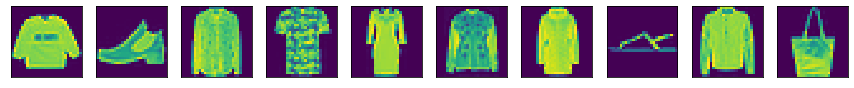

['pullover', 'ankle boot', 'shirt', 't-shirt', 'dress', 'coat', 'coat', 'sandal', 'coat', 'bag']


In [5]:
x, y = mnist_train[0:10]
show_images(x)
print(translate_labels(y))

In [6]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).sum().asscalar()

In [7]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += accuracy(net(X), y)
        n += y.size
    return acc_sum / n

In [8]:
batch_size = 256

transformer = gdata.vision.transforms.ToTensor()
num_workers = 0 if sys.platform.startswith('win32') else 4

train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
                              batch_size, shuffle=True,
                              num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
                             batch_size, shuffle=False,
                             num_workers=num_workers)

In [9]:
net = nn.Sequential()

with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Conv2D(channels=50, kernel_size=3, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(128, activation='relu'))
    net.add(gluon.nn.Dense(10))
net.initialize()

loss = gloss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [10]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = 0.
    train_acc = 0.
    n = 0
    for x, y in train_iter:
        with autograd.record():
            y_hat = net(x)
            l = loss(y_hat, y).sum()
        l.backward()
        trainer.step(batch_size)

        train_loss += l.asscalar()
        train_acc += accuracy(y_hat, y)
        n += y.size
        
    test_acc = evaluate_accuracy(test_iter, net)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
          % (epoch, train_loss / n, train_acc / n, test_acc))

epoch 1, loss 1.2167, train acc 0.549, test acc 0.708
epoch 2, loss 0.6794, train acc 0.738, test acc 0.790
epoch 3, loss 0.5509, train acc 0.789, test acc 0.827
epoch 4, loss 0.4814, train acc 0.820, test acc 0.839
epoch 5, loss 0.4337, train acc 0.841, test acc 0.848
epoch 6, loss 0.4045, train acc 0.853, test acc 0.864
epoch 7, loss 0.3800, train acc 0.861, test acc 0.871
epoch 8, loss 0.3620, train acc 0.868, test acc 0.875
epoch 9, loss 0.3468, train acc 0.873, test acc 0.881
epoch 10, loss 0.3343, train acc 0.879, test acc 0.880


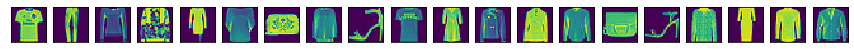

['t-shirt|t-shirt', 'trouser|trouser', 'pullover|pullover', 'pullover|shirt', 'dress|dress', 'pullover|pullover', 'bag|bag', 'shirt|shirt', 'sandal|sandal', 't-shirt|t-shirt', 'dress|dress', 'coat|coat', 'coat|coat', 'shirt|shirt', 'bag|bag', 'sandal|sandal', 'shirt|shirt', 'dress|dress', 'shirt|shirt', 'coat|coat']


In [11]:
for x, y in test_iter:
    break

true_labels = translate_labels(y.asnumpy())
pred_labels = translate_labels(net(x).argmax(axis=1).asnumpy())
titles = [true + '|' + pred for true, pred in zip(true_labels, pred_labels)]

show_images(x[0:20])
print(titles[0:20])